In [31]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import colors
from matplotlib.widgets import Slider
import matplotlib
import matplotlib.font_manager

from medmnist import VesselMNIST3D
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

TensorFlow version: 2.20.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [32]:
train_dataset = VesselMNIST3D(split='train', size=28, download=True)
trainx = []
trainy = []

test_dataset = VesselMNIST3D(split='test', size=28, download=True)
testx = []
testy = []

val_dataset = VesselMNIST3D(split='val', size=28, download=True)  # Fixed: was 'train'
valx = []
valy = []

for i in range(len(train_dataset)):
    trainx.append(train_dataset[i][0])
    trainy.append(train_dataset[i][1])

for i in range(len(test_dataset)):
    testx.append(test_dataset[i][0])
    testy.append(test_dataset[i][1])

for i in range(len(val_dataset)):
    valx.append(val_dataset[i][0])
    valy.append(val_dataset[i][1])

trainx_tensor = tf.convert_to_tensor(trainx, dtype=tf.float32)  # Using float32 for now
trainy_tensor = tf.convert_to_tensor(trainy, dtype=tf.float32)
testx_tensor = tf.convert_to_tensor(testx, dtype=tf.float32)
testy_tensor = tf.convert_to_tensor(testy, dtype=tf.float32)
valx_tensor = tf.convert_to_tensor(valx, dtype=tf.float32)
valy_tensor = tf.convert_to_tensor(valy, dtype=tf.float32)

print(f"\nData loaded successfully!")
print(f"Training set: {trainx_tensor.shape}")
print(f"Validation set: {valx_tensor.shape}")
print(f"Test set: {testx_tensor.shape}")



Data loaded successfully!
Training set: (1335, 1, 28, 28, 28)
Validation set: (191, 1, 28, 28, 28)
Test set: (382, 1, 28, 28, 28)


In [33]:
import numpy as np
from scipy.ndimage import rotate, zoom, shift
import tensorflow as tf

def augment_3d_volume(volume, num_augmentations=5):
    """
    Apply various 3D augmentations to a volume.
    
    Args:
        volume: numpy array with shape (C, D, H, W) where C is channel dimension
        num_augmentations: number of augmented copies to generate
    
    Returns:
        List of augmented volumes
    """
    augmented_volumes = []
    
    # Convert to numpy if it's a tensor
    if hasattr(volume, 'numpy'):
        volume = volume.numpy()
    
    original_shape = volume.shape
    
    for _ in range(num_augmentations):
        aug_volume = volume.copy()
        
        # Random rotation around spatial axes
        # Shape is (1, 28, 28, 28) so channel is first
        if np.random.rand() > 0.5:
            angle = np.random.uniform(-15, 15)
            # Choose axes for rotation (avoid channel dimension 0)
            axes_options = [(1, 2), (1, 3), (2, 3)]
            axes = axes_options[np.random.randint(0, len(axes_options))]
            aug_volume = rotate(aug_volume, angle, axes=axes, reshape=False, mode='nearest')
        
        # Random scaling/zoom
        if np.random.rand() > 0.5:
            scale_factor = np.random.uniform(0.9, 1.1)
            # Apply scale to spatial dimensions only (not channel)
            zoom_factors = [1, scale_factor, scale_factor, scale_factor]
            aug_volume = zoom(aug_volume, zoom_factors, mode='nearest')
            aug_volume = resize_to_original(aug_volume, original_shape)
        
        # Random flip along spatial axes
        if np.random.rand() > 0.5:
            axis = np.random.randint(1, 4)  # Flip along axis 1, 2, or 3 (not channel 0)
            aug_volume = np.flip(aug_volume, axis=axis)
        
        # Random shift along spatial dimensions
        if np.random.rand() > 0.5:
            # No shift for channel dimension, random shift for spatial
            shift_amount = [0] + [np.random.randint(-3, 4) for _ in range(3)]
            aug_volume = shift(aug_volume, shift_amount, mode='nearest')
        
        # Add slight Gaussian noise
        if np.random.rand() > 0.5:
            noise = np.random.normal(0, 0.01, aug_volume.shape)
            aug_volume = aug_volume + noise
            aug_volume = np.clip(aug_volume, 0, 1)
        
        # Random brightness adjustment
        if np.random.rand() > 0.5:
            brightness_factor = np.random.uniform(0.9, 1.1)
            aug_volume = aug_volume * brightness_factor
            aug_volume = np.clip(aug_volume, 0, 1)
        
        # Random contrast adjustment
        if np.random.rand() > 0.5:
            mean = np.mean(aug_volume)
            aug_volume = (aug_volume - mean) * np.random.uniform(0.9, 1.1) + mean
            aug_volume = np.clip(aug_volume, 0, 1)
        
        # Random elastic deformation (subtle)
        if np.random.rand() > 0.7:
            aug_volume = elastic_transform_3d(aug_volume, alpha=5, sigma=3)
        
        augmented_volumes.append(aug_volume)
    
    return augmented_volumes

def elastic_transform_3d(volume, alpha=10, sigma=3):
    """Apply elastic deformation to 3D volume."""
    # Only apply to spatial dimensions (not channel)
    shape = volume.shape[1:]  # Spatial dimensions
    
    # Generate random displacement fields
    dx = np.random.randn(*shape) * sigma
    dy = np.random.randn(*shape) * sigma
    dz = np.random.randn(*shape) * sigma
    
    # Smooth the displacement fields
    from scipy.ndimage import gaussian_filter
    dx = gaussian_filter(dx, sigma, mode='constant') * alpha
    dy = gaussian_filter(dy, sigma, mode='constant') * alpha
    dz = gaussian_filter(dz, sigma, mode='constant') * alpha
    
    # Create meshgrid
    z, y, x = np.meshgrid(
        np.arange(shape[0]),
        np.arange(shape[1]),
        np.arange(shape[2]),
        indexing='ij'
    )
    
    indices = [
        np.clip(z + dz, 0, shape[0] - 1).astype(int),
        np.clip(y + dy, 0, shape[1] - 1).astype(int),
        np.clip(x + dx, 0, shape[2] - 1).astype(int)
    ]
    
    # Apply transformation to each channel
    result = np.zeros_like(volume)
    for c in range(volume.shape[0]):
        result[c] = volume[c][indices[0], indices[1], indices[2]]
    
    return result

def resize_to_original(volume, target_shape):
    """Resize volume to match target shape by cropping or padding."""
    current_shape = volume.shape
    result = volume.copy()
    
    for i in range(len(target_shape)):
        if current_shape[i] > target_shape[i]:
            # Crop
            diff = current_shape[i] - target_shape[i]
            start = diff // 2
            end = start + target_shape[i]
            result = np.take(result, range(start, end), axis=i)
        elif current_shape[i] < target_shape[i]:
            # Pad
            diff = target_shape[i] - current_shape[i]
            pad_before = diff // 2
            pad_after = diff - pad_before
            pad_width = [(0, 0)] * len(target_shape)
            pad_width[i] = (pad_before, pad_after)
            result = np.pad(result, pad_width, mode='edge')
    
    return result

# Augment Class 1 samples
print("Augmenting Class 1 (Aneurysm) samples...")

augmented_trainx = []
augmented_trainy = []

# Find Class 1 samples
# First, flatten the labels properly
trainy_flat = [label.flatten()[0] if hasattr(label, 'flatten') else label for label in trainy]
class1_indices = [i for i, label in enumerate(trainy_flat) if label == 1]
print(f"Found {len(class1_indices)} Class 1 samples")

# Adjust this to balance your dataset
num_augmentations_per_sample = 6  # Creates ~900 additional samples

print("Generating augmentations...")
for i, idx in enumerate(class1_indices):
    if i % 30 == 0:
        print(f"  Processing sample {i+1}/{len(class1_indices)}")
    
    original_volume = trainx[idx]
    augmented_volumes = augment_3d_volume(original_volume, num_augmentations_per_sample)
    
    for aug_vol in augmented_volumes:
        augmented_trainx.append(aug_vol)
        augmented_trainy.append(1)  # Class 1 label as scalar

print(f"Generated {len(augmented_trainx)} augmented samples for Class 1")

# Combine original and augmented data
trainx_combined = trainx + augmented_trainx

# Flatten all labels properly
trainy_combined_flat = []
for label in trainy:
    if isinstance(label, np.ndarray):
        trainy_combined_flat.append(label.flatten()[0])
    else:
        trainy_combined_flat.append(label)
        
# Add augmented labels (already scalars)
trainy_combined_flat.extend(augmented_trainy)

# Convert to tensors
trainx_tensor = tf.convert_to_tensor(trainx_combined, dtype=tf.float32)
trainy_tensor = tf.convert_to_tensor(trainy_combined_flat, dtype=tf.float32)

print(f"\nAugmented Training set shapes:")
print(f"  X: {trainx_tensor.shape}")
print(f"  y: {trainy_tensor.shape}")

# Check new class distribution
train_labels_aug = np.array(trainy_combined_flat).flatten()
unique_aug, counts_aug = np.unique(train_labels_aug, return_counts=True)
print(f"\n{'='*60}")
print(f"Class Distribution Comparison:")
print(f"{'='*60}")
print(f"Original Training - Class 0: {counts_train[0]}, Class 1: {counts_train[1]}")
print(f"                    Ratio: {counts_train[1]/counts_train[0]:.3f}")
print(f"\nAugmented Training - Class 0: {counts_aug[0]}, Class 1: {counts_aug[1]}")
print(f"                     Ratio: {counts_aug[1]/counts_aug[0]:.3f}")
print(f"{'='*60}")

# Optional: Visualize a few augmented samples
print("\nSample augmentation check:")
print(f"Original sample shape: {trainx[class1_indices[0]].shape}")
print(f"Augmented sample shape: {augmented_trainx[0].shape}")

Augmenting Class 1 (Aneurysm) samples...
Found 150 Class 1 samples
Generating augmentations...
  Processing sample 1/150
  Processing sample 31/150
  Processing sample 61/150
  Processing sample 91/150
  Processing sample 121/150
Generated 900 augmented samples for Class 1

Augmented Training set shapes:
  X: (2235, 1, 28, 28, 28)
  y: (2235,)

Class Distribution Comparison:
Original Training - Class 0: 1185, Class 1: 150
                    Ratio: 0.127

Augmented Training - Class 0: 1185, Class 1: 1050
                     Ratio: 0.886

Sample augmentation check:
Original sample shape: (1, 28, 28, 28)
Augmented sample shape: (1, 28, 28, 28)


In [ ]:
# # Example 1: 3D Voxel Visualization
# fig = plt.figure(figsize=(10, 8))
# vol = np.squeeze(trainx[1], axis=0)  # shape (28, 28, 28)
# ax = fig.add_subplot(111, projection='3d')

# filled = vol > 0
# norm = colors.Normalize(vmin=vol.min(), vmax=vol.max())
# cmap = plt.cm.viridis
# facecolors = cmap(norm(vol))
# alpha = np.clip(vol, 0, 1)
# facecolors[..., 3] = alpha
# facecolors[~filled, 3] = 0.0

# ax.voxels(filled, facecolors=facecolors)
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_zlabel('Z-axis')
# plt.title(f'3D Voxel Visualization - Label: {trainy[1]}')
# plt.show()

# # Example 2: Orthogonal Slices (Middle Slices)
# vol = np.array(trainx[0]).squeeze()
# i_mid = vol.shape[0] // 2
# j_mid = vol.shape[1] // 2
# k_mid = vol.shape[2] // 2

# fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# axes[0].imshow(vol[i_mid, :, :], cmap='gray')
# axes[0].set_title(f'Axial (i={i_mid}) - Label: {trainy[0]}')
# axes[0].axis('off')

# axes[1].imshow(vol[:, j_mid, :], cmap='gray')
# axes[1].set_title(f'Coronal (j={j_mid})')
# axes[1].axis('off')

# axes[2].imshow(vol[:, :, k_mid], cmap='gray')
# axes[2].set_title(f'Sagittal (k={k_mid})')
# axes[2].axis('off')

# plt.tight_layout()
# plt.show()

# # Example 3: Show healthy vs aneurysm examples
# healthy_idx = np.where(train_labels == 0)[0][0]
# aneurysm_idx = np.where(train_labels == 1)[0][0]

# fig, axes = plt.subplots(2, 3, figsize=(12, 8))
# fig.suptitle('Healthy vs Aneurysm Comparison', fontsize=14, fontweight='bold')

# # Healthy example
# vol_healthy = np.array(trainx[healthy_idx]).squeeze()
# mid = vol_healthy.shape[0] // 2
# axes[0, 0].imshow(vol_healthy[mid, :, :], cmap='gray')
# axes[0, 0].set_title('Healthy - Axial')
# axes[0, 0].axis('off')
# axes[0, 1].imshow(vol_healthy[:, mid, :], cmap='gray')
# axes[0, 1].set_title('Healthy - Coronal')
# axes[0, 1].axis('off')
# axes[0, 2].imshow(vol_healthy[:, :, mid], cmap='gray')
# axes[0, 2].set_title('Healthy - Sagittal')
# axes[0, 2].axis('off')

# # Aneurysm example
# vol_aneurysm = np.array(trainx[aneurysm_idx]).squeeze()
# mid = vol_aneurysm.shape[0] // 2
# axes[1, 0].imshow(vol_aneurysm[mid, :, :], cmap='gray')
# axes[1, 0].set_title('Aneurysm - Axial')
# axes[1, 0].axis('off')
# axes[1, 1].imshow(vol_aneurysm[:, mid, :], cmap='gray')
# axes[1, 1].set_title('Aneurysm - Coronal')
# axes[1, 1].axis('off')
# axes[1, 2].imshow(vol_aneurysm[:, :, mid], cmap='gray')
# axes[1, 2].set_title('Aneurysm - Sagittal')
# axes[1, 2].axis('off')

# plt.tight_layout()
# plt.show()


In [34]:
# From (1335, 1, 28, 28, 28) to (1335, 28, 28, 28, 1)
trainx_tensor = tf.transpose(trainx_tensor, [0, 2, 3, 4, 1])
valx_tensor = tf.transpose(valx_tensor, [0, 2, 3, 4, 1])
testx_tensor = tf.transpose(testx_tensor, [0, 2, 3, 4, 1])

print(f"After transpose - Training data shape: {trainx_tensor.shape}")

# Normalize data to [0, 1] range
trainx_norm = trainx_tensor / 255.0
valx_norm = valx_tensor / 255.0
testx_norm = testx_tensor / 255.0

# Flatten labels
trainy_flat = tf.squeeze(trainy_tensor)
valy_flat = tf.squeeze(valy_tensor)
testy_flat = tf.squeeze(testy_tensor)

print(f"Normalized training data shape: {trainx_norm.shape}")
print(f"Training labels shape: {trainy_flat.shape}")
print(f"Data range: [{tf.reduce_min(trainx_norm):.3f}, {tf.reduce_max(trainx_norm):.3f}]")

# Calculate class weights for imbalanced data
class_weight = {
    0: len(train_labels_aug) / (2 * counts_aug[0]),
    1: len(train_labels_aug) / (2 * counts_aug[1])
}
print(f"\nClass weights to handle imbalance: {class_weight}")

After transpose - Training data shape: (2235, 28, 28, 28, 1)
Normalized training data shape: (2235, 28, 28, 28, 1)
Training labels shape: (2235,)
Data range: [-0.002, 0.006]

Class weights to handle imbalance: {0: np.float64(0.9430379746835443), 1: np.float64(1.0642857142857143)}


In [35]:

"""
Architecture Design Rationale:
- 3D Convolutional layers to capture spatial relationships in volumetric data
- Progressive downsampling (28→14→7→3) to build hierarchical features
- Batch normalization for training stability
- Dropout for regularization (critical for small dataset)
- Dense layers for final classification
- Sigmoid activation for binary classification

The architecture processes the 3D volume through multiple convolutional blocks,
each extracting increasingly abstract features before making a classification.
"""

def build_3d_cnn(input_shape=(28, 28, 28, 1), dropout_rate=0.3):
    """
    Build a 3D CNN for binary classification of vessel segments
    
    Parameters:
    - input_shape: Shape of input 3D volume with channel
    - dropout_rate: Dropout probability for regularization
    
    Returns:
    - Compiled Keras model
    """
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Block 1: Initial feature extraction (28x28x28 → 14x14x14)
        layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(dropout_rate),
        
        # Block 2: Deeper features (14x14x14 → 7x7x7)
        layers.Conv3D(64, kernel_size=(3, 3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(dropout_rate),
        
        # Block 3: High-level features (7x7x7 → 3x3x3)
        layers.Conv3D(128, kernel_size=(3, 3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.Dropout(dropout_rate),
        
        # Global pooling to reduce parameters
        layers.GlobalAveragePooling3D(),
        
        # Dense layers for classification
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dropout(dropout_rate),
        
        # Output layer (sigmoid for binary classification)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Build and display model
model = build_3d_cnn(input_shape=(28, 28, 28, 1), dropout_rate=0.3)
model.summary()

print("\nTotal parameters:", model.count_params())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_9 (Conv3D)               │ (None, 28, 28, 28, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 28, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 14, 14, 14, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 14, 14, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_10 (Conv3D)              │ (None, 14, 14, 14, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 14, 14, 14, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 7, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 7, 7, 7, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 7, 7, 7, 128)   │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 7, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 3, 3, 3, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 3, 3, 3, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d_3      │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 328,001 (1.25 MB)

 Trainable params: 327,553 (1.25 MB)

 Non-trainable params: 448 (1.75 KB)


Total parameters: 328001


In [ ]:
# plot_model(
#     model,
#     to_file="3d_cnn_architecture.png",
#     show_shapes=True,        # show tensor shapes
#     show_layer_names=True,   # show layer names (Conv3D, Dense, etc.)
#     dpi=160,                 # higher resolution
#     expand_nested=False
# )

In [36]:
"""
Loss Function: Binary Crossentropy
- Standard for binary classification tasks
- Measures difference between predicted and actual probabilities

Optimizer: Adam
- Adaptive learning rate optimizer
- Works well with default parameters for most problems

Metrics:
- Accuracy: Overall correctness
- AUC: Area Under ROC Curve - crucial for imbalanced medical datasets
  Measures the model's ability to distinguish between classes
"""

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc')]
)

print("Model compiled with:")
print("- Optimizer: Adam (lr=0.001)")
print("- Loss: Binary Crossentropy")
print("- Metrics: Accuracy, AUC")


Model compiled with:
- Optimizer: Adam (lr=0.001)
- Loss: Binary Crossentropy
- Metrics: Accuracy, AUC


In [37]:

# Early stopping to prevent overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_auc',
    patience=15,
    restore_best_weights=True,
    mode='max',
    verbose=1
)

# Reduce learning rate when validation loss plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Save best model
checkpoint = keras.callbacks.ModelCheckpoint(
    'best_vessel_model.h5',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)

print("\nCallbacks configured:")
print("- Early Stopping: patience=15, monitor=val_auc")
print("- ReduceLROnPlateau: factor=0.5, patience=5")
print("- ModelCheckpoint: saves best val_auc")



Callbacks configured:
- Early Stopping: patience=15, monitor=val_auc
- ReduceLROnPlateau: factor=0.5, patience=5
- ModelCheckpoint: saves best val_auc


In [38]:
# Train for 2 epochs to confirm the model is working
history = model.fit(
    trainx_norm, trainy_flat,
    batch_size=16,
    epochs=2,
    validation_data=(valx_norm, valy_flat),
    class_weight=class_weight,
    verbose=1
)

print("\n" + "="*70)
print("INITIAL TEST RESULTS")
print("="*70)
print(f"Epoch 1 → Training Loss: {history.history['loss'][0]:.4f}, "
      f"Val Loss: {history.history['val_loss'][0]:.4f}")
print(f"Epoch 2 → Training Loss: {history.history['loss'][1]:.4f}, "
      f"Val Loss: {history.history['val_loss'][1]:.4f}")
print(f"\nTraining AUC: {history.history['auc'][-1]:.4f}")
print(f"Validation AUC: {history.history['val_auc'][-1]:.4f}")

# Check if loss is decreasing (sign of learning)
if history.history['loss'][1] < history.history['loss'][0]:
    print("\n Loss is decreasing - model is learning!")
else:
    print("\n Loss not decreasing - may need to adjust hyperparameters")


Epoch 1/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7217 - auc: 0.8063 - loss: 0.5317 - val_accuracy: 0.1152 - val_auc: 0.5000 - val_loss: 2.3705
Epoch 2/2
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8206 - auc: 0.9020 - loss: 0.3838 - val_accuracy: 0.1152 - val_auc: 0.5000 - val_loss: 11.2928

INITIAL TEST RESULTS
Epoch 1 → Training Loss: 0.5317, Val Loss: 2.3705
Epoch 2 → Training Loss: 0.3838, Val Loss: 11.2928

Training AUC: 0.9020
Validation AUC: 0.5000

 Loss is decreasing - model is learning!


Starting full training session...
Epoch 1/100
67/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9843 - auc: 0.9994 - loss: 0.0374
Epoch 1: val_auc did not improve from 0.98171
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9866 - auc: 0.9994 - loss: 0.0329 - val_accuracy: 0.5654 - val_auc: 0.8509 - val_loss: 3.0543 - learning_rate: 6.2500e-05
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9862 - auc: 0.9988 - loss: 0.0351
Epoch 2: val_auc did not improve from 0.98171
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9866 - auc: 0.9989 - loss: 0.0343 - val_accuracy: 0.2147 - val_auc: 0.6331 - val_loss: 8.5967 - learning_rate: 6.2500e-05
Epoch 3/100
66/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9888 - auc: 0.9996 - loss: 0.0295
Epoch 3: val_auc did not improve from 0.98171
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9902 - auc: 0.9995 - loss: 0.0298 - val_accuracy: 0.3089 - val_auc: 0.6982 - val_loss: 6.7465 - learning_rate: 6.2500e-05
Epoch 

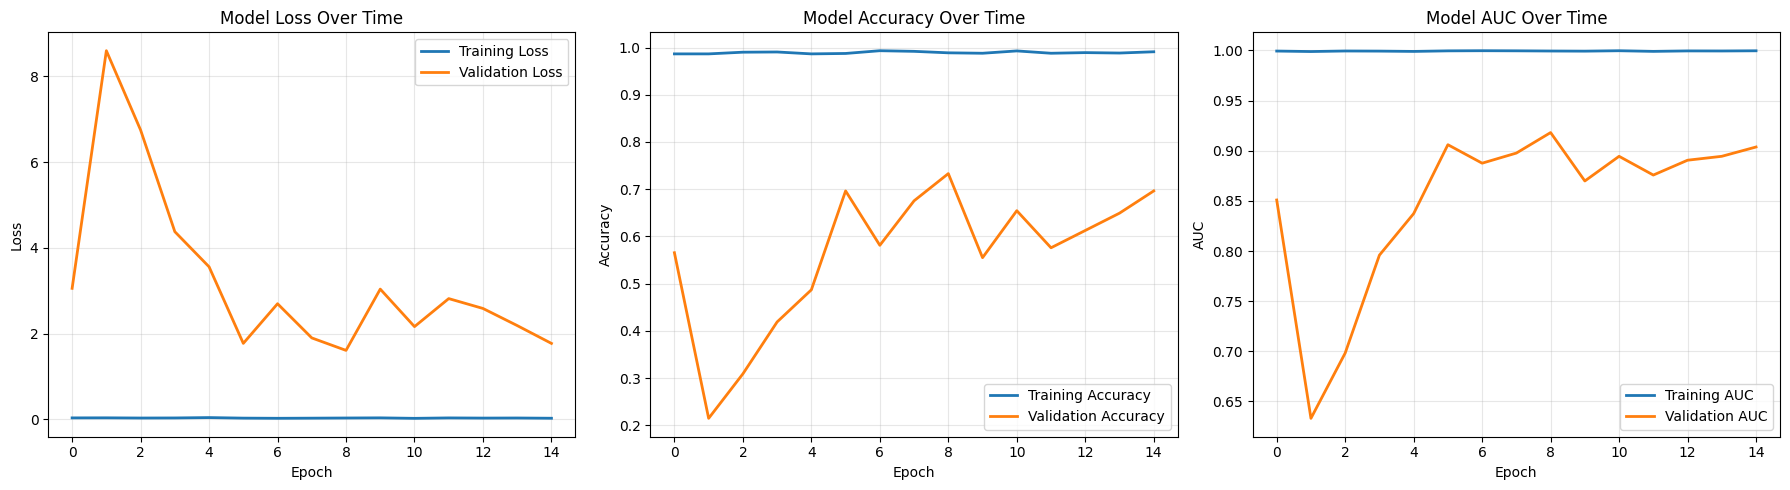

In [40]:
print("Starting full training session...")

# For GPU: can use float16 to save memory
# trainx_tensor = tf.cast(trainx_tensor, tf.float16) / 255.0
# valx_tensor = tf.cast(valx_tensor, tf.float16) / 255.0
# model = build_3d_cnn(input_shape=(28, 28, 28, 1), dropout_rate=0.3)
# model.compile(...) # recompile for float16

history_full = model.fit(
    trainx_norm, trainy_flat,
    batch_size=32,  # Larger batch for GPU
    epochs=100,  # Will stop early with callback
    validation_data=(valx_norm, valy_flat),
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history_full.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history_full.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Model Loss Over Time')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history_full.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history_full.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy Over Time')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AUC
axes[2].plot(history_full.history['auc'], label='Training AUC', linewidth=2)
axes[2].plot(history_full.history['val_auc'], label='Validation AUC', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].set_title('Model AUC Over Time')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()





MODEL EVALUATION ON TEST SET



Test Loss: 0.2463
Test Accuracy: 0.9398
Test AUC: 0.9193

Classification Report:
              precision    recall  f1-score   support

     Healthy     0.9514    0.9823    0.9666       339
    Aneurysm     0.8125    0.6047    0.6933        43

    accuracy                         0.9398       382
   macro avg     0.8820    0.7935    0.8300       382
weighted avg     0.9358    0.9398    0.9359       382



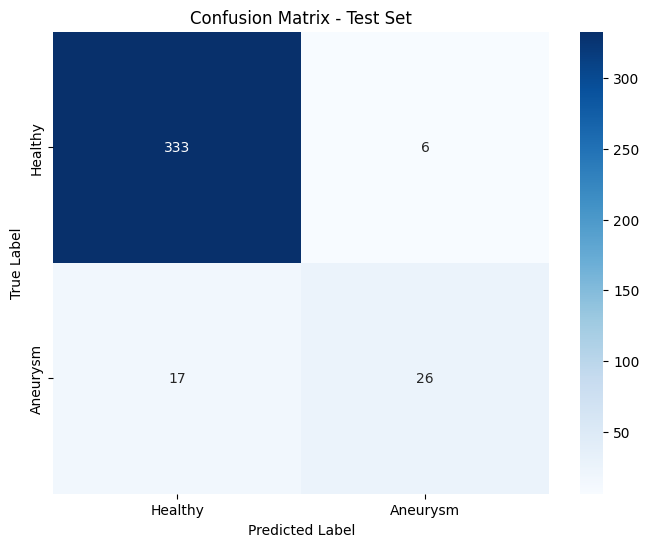

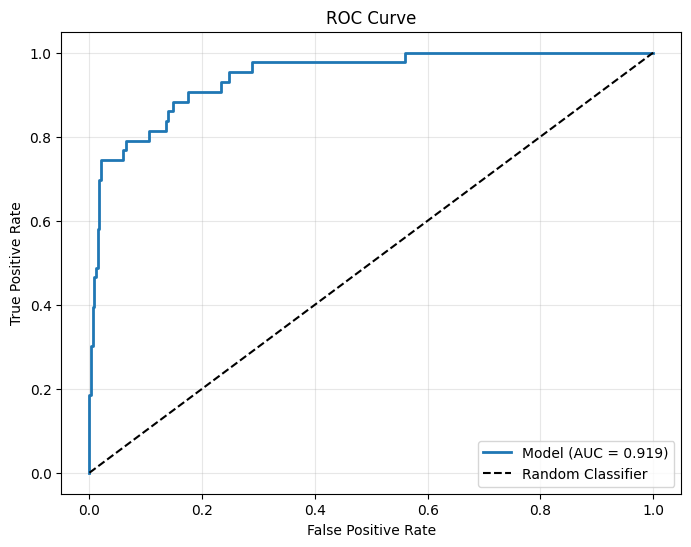

In [41]:


print("\n" + "="*70)
print("MODEL EVALUATION ON TEST SET")
print("="*70)

# Load best model
model = keras.models.load_model('best_vessel_model.h5')

# Evaluate on test set
test_loss, test_acc, test_auc = model.evaluate(testx_norm, testy_flat, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Get predictions
y_pred_proba = model.predict(testx_norm, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, y_pred, 
                          target_names=['Healthy', 'Aneurysm'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'Model (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [43]:

print("VesselMNIST3D Baseline Performance (from MedMNIST paper):")
print("- ResNet18 (3D): AUC ~0.920, ACC ~0.890")
print("- Auto-sklearn: AUC ~0.917, ACC ~0.887")
print("\nModel Performance:")
print(f"- Test AUC: {test_auc:.4f}")
print(f"- Test ACC: {test_acc:.4f}")

if test_auc >= 0.920:
    print("\nmodel matches or exceeds the baseline!")
elif test_auc >= 0.900:
    print("\n Good performance! Close to the baseline.")
else:
    print("\nRoom for improvement")
    

VesselMNIST3D Baseline Performance (from MedMNIST paper):
- ResNet18 (3D): AUC ~0.920, ACC ~0.890
- Auto-sklearn: AUC ~0.917, ACC ~0.887

Model Performance:
- Test AUC: 0.9193
- Test ACC: 0.9398

 Good performance! Close to the baseline.
